Created 8/10/2025 <br>
Written by Shawn Newman (With code stolen from Steven Corum and Alex Seaver)

In [1]:
import matplotlib.pyplot as plt  # Plotting graphs and visualizing data
from matplotlib.ticker import MultipleLocator, LogLocator # Used for ticks in logarithmic plots
import numpy as np               # Numerical operations, particularly with arrays
import pandas as pd              # Data manipulation and analysis
import os
import importlib.util

# This imports a custom library of python functions from a higher directory
quiet=True
current_dir = "."
target_file = "ICASL.py"
target_name = "ICASL"
while True:
    if not quiet: print(current_dir)
    # Check if ICASL is in the current directory
    ICASL_path = os.path.join(current_dir, target_file)
    if not quiet: print(ICASL_path)
    if os.path.isfile(ICASL_path):
        # Loads ICASL.py
        spec = importlib.util.spec_from_file_location(target_name, ICASL_path)
        ICASL = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(ICASL)
        break
    else:
        # Move one level up
        parent_dir = os.path.join(current_dir, "..")
        if not quiet: print(parent_dir)
        if current_dir == parent_dir:  # Reached the root directory
            raise ValueError("ICASL.py not found")
        else:
            current_dir = parent_dir
ICASL.test()

ICASL is loaded!


<h3> Calc Functions </h3>

In [2]:
# Determines coordinates of peak
def tran_peak(times, values, settling_direction, log=False):
    if (settling_direction.lower() in ["up", "rising"]): peak_value = min(values)
    elif (settling_direction.lower() in ["down", "falling"]): peak_value = max(values)
    peak_time = times[np.where(values == peak_value)[0]][0]
    if log:
        print(f"Peak Time: {peak_time}")
        print(f"Peak Value: {peak_value}")
    return peak_time, peak_value

# Determines coordinates where transient is officially settled
def tran_settle(times, values, peak_value, settling_threshold, log=False):
    settled_value = np.mean(values[-3:-1])
    threshold = abs(peak_value*settling_threshold)
    # These are the indices of every piece of data whose y value is not within the settled threshold
    unsettled_indices = np.where(np.logical_or(values > settled_value+threshold, values < settled_value-threshold))[0]
    if len(unsettled_indices) == 0: 
        print("Error: Signal is always settled.")
        settled_time = times[0]
    else:
        last_unsettled_time = times[unsettled_indices[-1]]
        if log: print(f"Last Unsettled Time: {last_unsettled_time}")
        if times[-1] != last_unsettled_time:
            settled_time = times[unsettled_indices[-1]+1] # If your data range is too narrow and signal is oscillating, this may run while unsettled.
        else:
            print("Warning: Not settled by final time")
            settled_time = times[-1]
    if log:
        print(f"Settled Value: {settled_value}")
        print(f"Unsettled Indices: {unsettled_indices}")
        print(f"Unsettled Times: {times[unsettled_indices]}")
        print(f"Unsettled Values: {values[unsettled_indices]}")
        print(f"Within Threshold Times: {np.array([x for x in times if x not in times[unsettled_indices]])}")
        print(f"Within Threshold Values: {np.array([x for x in values if x not in values[unsettled_indices]])}")
        print(f"Settled Time: {settled_time}")
    return settled_time, settled_value

# Determines coordinates where transient first begins
def tran_start(times, values, log=False):
    # I thought it'd be fun to detect the start of transients (although uneccesary, usually already known) -- I trace through each time step, 
    # finding the standard deviation shortly before and after, then take a ratio of those two stds. This ratio is within 20 and .05 everywhere 
    # except around start of the transient, where it spikes to the 1,000's (with interpolation, stays within 5 and .2 and spikes to 1,000,000s)
    # To find the exact point where the transient begins, I find the maximum drop in this ratio from one time step to the next. 
    std_ratios = []
    drops = []
    std_width = 10
    if (len(values) < 30):
        print("Error: only {len(values)} data points. Cannot compute transient calculations.")
        starting_time = 0
        starting_value = 0
    else:
        for i, value, time in zip(range(len(values)), values, times):
            if (i < std_width or i+std_width >= len(values)): std_ratios.append(1) ; drops.append(1) ; continue
            if (values[i-std_width] == values[i-std_width+1]): std_ratios.append(1) ; drops.append(1) ; continue
            if (values[i+std_width] == values[i+std_width-1]): std_ratios.append(1) ; drops.append(1) ; continue
            past_std = np.std(values[i-std_width:i])
            future_std = np.std(values[i:i+std_width])
            std_ratio = future_std/past_std
            std_ratios.append(std_ratio)
            drops.append(std_ratios[i-1]/std_ratios[i])
            if log: print(f"Index {i} : Time {time}: Value {value} : Ratio {future_std/past_std}")
        starting_time = times[drops.index(max(drops))-2]
        starting_value = values[np.where(times == starting_time)[0]][0]
    if log:
        print(f"Starting Value: {starting_value}")
        print(f"Starting Time: {starting_time}")
    return starting_time, starting_value

def find_closest(listA, target):
    return min(listA, key=lambda x: abs(x - target)) # Minimum of difference between a value and every value in a list -- finds closest value

def convert_from_decibels(dB):
    return 10**(dB/20)

# Assumes gains and phases are perfectly aligned -- would need to use frequency as a middleman otherwise
def gain_margin_calc(gains, phases, log=False):
    inverted_phase = find_closest(phases, phases[0]-180)
    gain_reference = gains[phases == inverted_phase]
    gain_margin = 0-gain_reference
    if log: print(f"Gain Margin: {gain_margin}")
    return gain_margin

# Assumes gains and phases are perfectly aligned
def phase_margin_calc(gains, phases, log=False):
    zero_gain = find_closest(gains, 0)
    phase_reference = phases[gains == zero_gain]-phases[0]
    phase_margin = (phase_reference+180)
    if log: print(f"Phase Margin: {phase_margin}")
    return phase_margin

def gain_bandwidth_calc(freqs, gains, test_frequency, log=False):
    freq = find_closest(freqs, test_frequency)
    GB = convert_from_decibels(gains[freqs == freq]) * freq
    if log: print(f"Gain Bandwidth: {GB} (Hz)")
    return GB

def crossover_freq_calc(freqs, gains):
    zero_gain = find_closest(gains, 0)
    crossover_freq = freqs[gains == zero_gain]
    return crossover_freq

<h3> Transient </h3>

Layer 1 of keys for Temp: [27, 125, -55, -180]
Layer 2 of keys for VREF: [0.6, 0.7, 0.8, 0.9, 1.0]
Final dataframe columns: ['time', 'VREF']

Layer 1 of keys for Temp: [27, 125, -55, -180]
Layer 2 of keys for VREF: [0.6, 0.7, 0.8, 0.9, 1.0]
Final dataframe columns: ['time', 'VOUT']

Layer 1 of keys for Temp: [-180, -55, 27, 125]
Final dataframe columns: ['time', 'IL']

Layer 1 of keys for VREF: [0.6, 0.7, 0.8, 0.9, 1.0]
Final dataframe columns: ['temp', 'IQ']



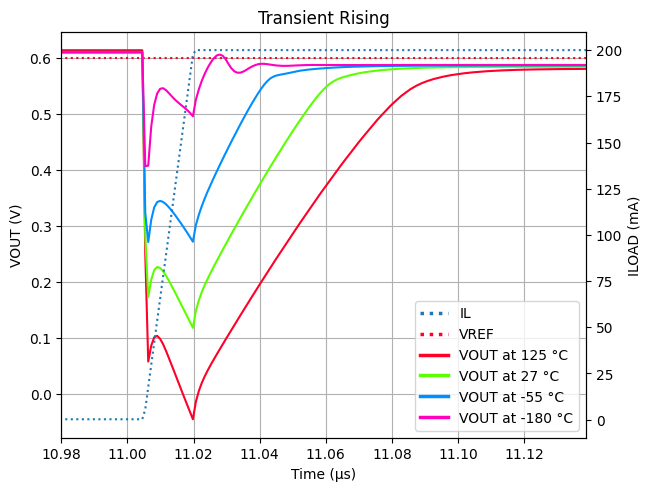

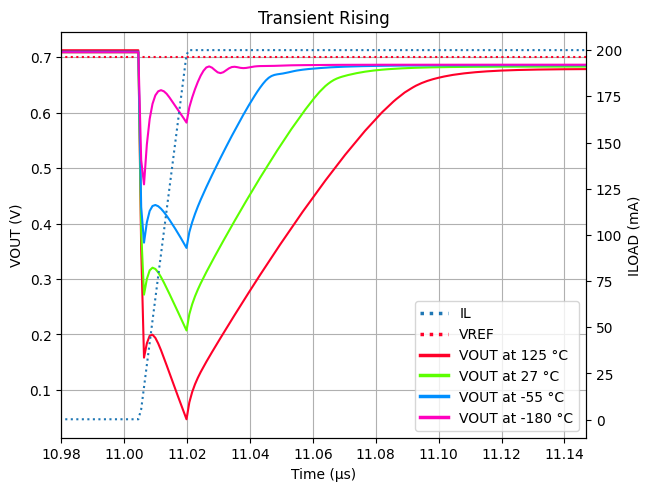

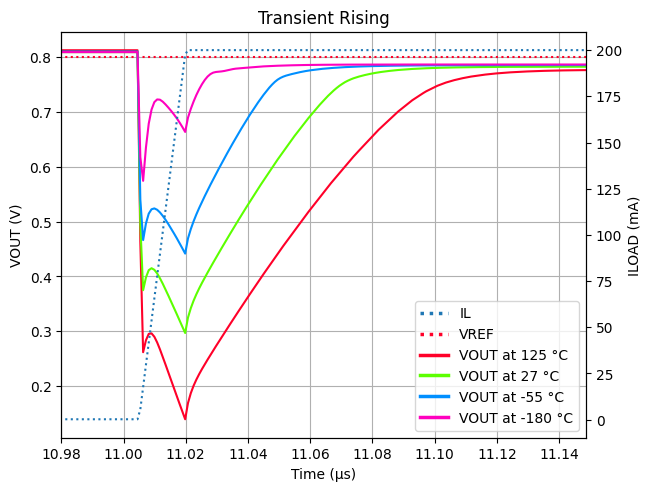

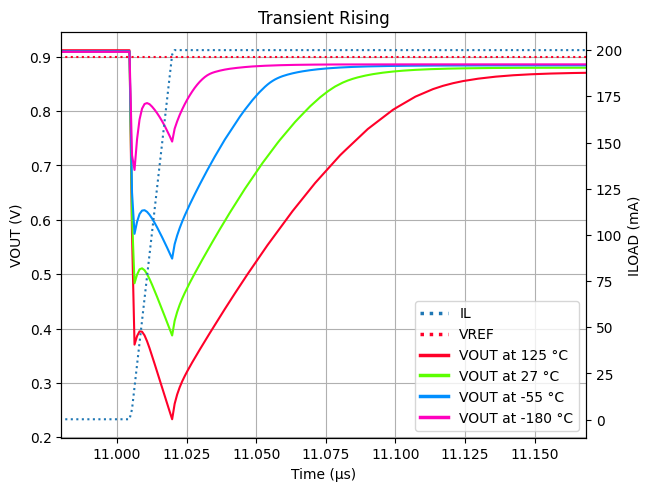

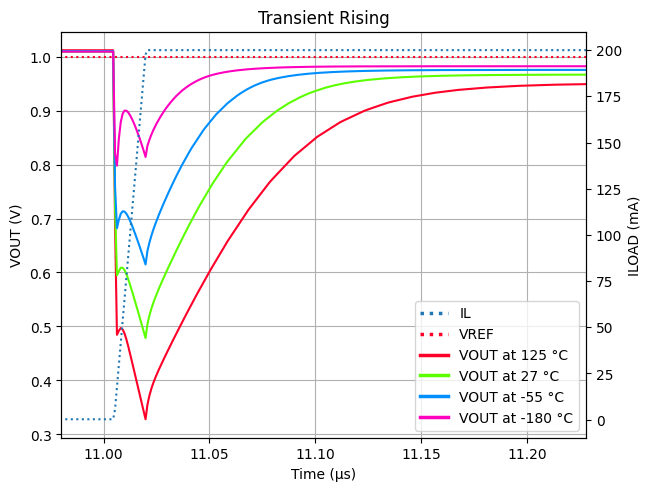

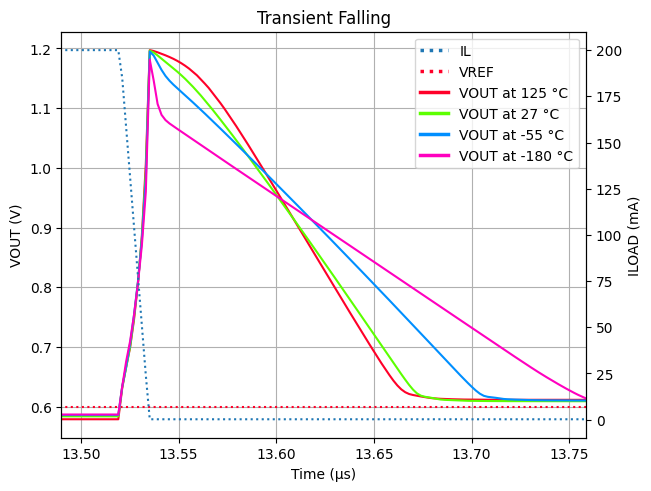

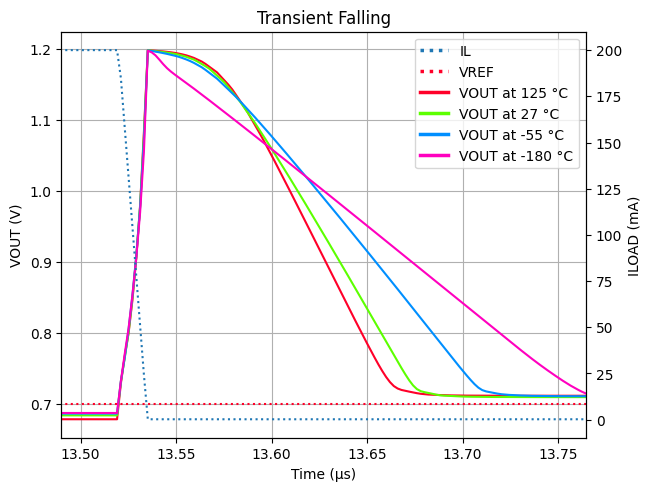

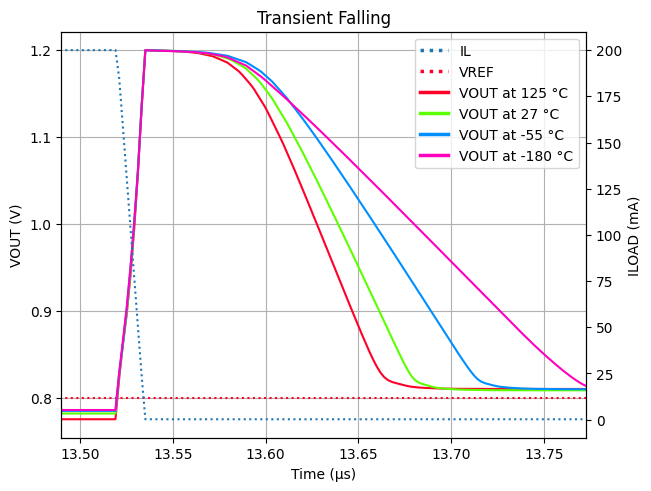

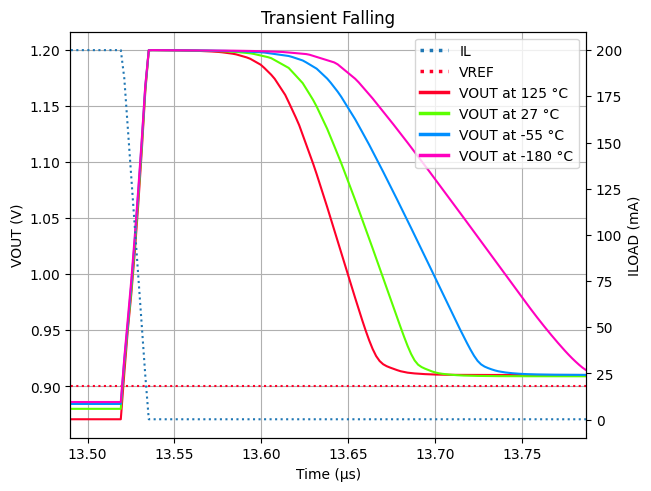

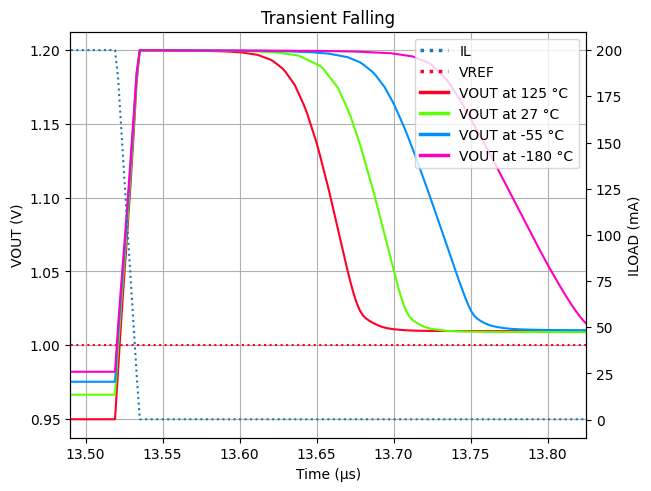

In [3]:
# Read in data
sim_dir = "Sim_Data"
tran_dir = os.path.join(sim_dir, "Transient_Sims")
VREF_data, [temps, VREFs] = ICASL.read_cadence_csv(os.path.join(tran_dir, "TI_RLDO_VREF.csv"), ["Temp", "VREF"], new_x_label = "time", new_y_label = "VREF")
VOUT_data, [temps, VREFs] = ICASL.read_cadence_csv(os.path.join(tran_dir, "TI_RLDO_VOUT.csv"), ["Temp", "VREF"], new_x_label = "time", new_y_label = "VOUT")
IL_data, [temps] = ICASL.read_cadence_csv(os.path.join(tran_dir, "TI_RLDO_IL.csv"), ["Temp"], new_x_label = "time", new_y_label = "IL")
IQ_data, [VREFs] = ICASL.read_cadence_csv(os.path.join(tran_dir, "TI_RLDO_IQ.csv"), ["VREF"], new_x_label = "temp", new_y_label = "IQ")

temps.sort(reverse=True)

# Example data structure usage:
VOUT_data[27][0.6] # This outputs a 2 column dataframe for temp=27 and VREF=0.6. Those columns were renamed to "time"(x) and "VREF"(y).

def transient_plot(start_data, end_data, start_plot, legend_location, type, log=False):
    ts = 1e-6 # Time scale
    settling_threshold = .005
    start_data = start_data*ts
    end_data = end_data*ts
    tran_metrics = []
    for VREF in VREFs:
        # Plot VREF
        VREF_df = VREF_data[27][VREF]                                              # Obtains desired VREF dataframe at 27 degrees
        VREF_df = ICASL.limit_data(VREF_df, "time", start_data, end_data)          # Cuts off data outside provided bounds
        fig, ax1 = ICASL.start_plot(f"Transient {type}", f"Time (µs)", "VOUT (V)") # Default plot creation/styling
        ax2 = ax1.twinx()                                                          # Adds current axis on right side
        ax1.ticklabel_format(useOffset=False)                                      # Gets rid of automatic offset for all x values
        t = np.linspace(start_data, end_data, 1000)                                # Creates a new set of 1000 times across data range
        VREF_inter = np.interp(t, VREF_df["time"], VREF_df["VREF"])                # Interpolates (linearly) to fill this new time range with data
        ax1.plot(t/ts, VREF_inter, label=f"VREF", linestyle='dotted')

        # Plot IL
        IL_df = IL_data[27]
        IL_df = ICASL.limit_data(IL_df, "time", start_data, end_data)
        IL_inter = np.interp(t, IL_df["time"], IL_df["IL"])
        ax2.set_ylabel(f"ILOAD ({ICASL.prefix(IL_df['IL'])}A)")                 # Current's Engineering Notation prefix is automatically determined
        ax2.plot(t/ts, ICASL.scale(IL_inter), label=f"IL", linestyle='dotted')  # Current scaled between 1-999 for Engineering Notation

        settled_times = [] # Used for determining x limit
        cm_num = 4
        cm=plt.get_cmap('gist_rainbow')
        ax1.set_prop_cycle('color', cm(np.linspace(0, 1, cm_num)))
        for temp in temps:
            # Plot VOUT
            VOUT_df = VOUT_data[temp][VREF]
            VOUT_df = ICASL.limit_data(VOUT_df, "time", start_data, end_data)
            VOUT_inter = np.interp(t, VOUT_df["time"], VOUT_df["VOUT"])
            ax1.plot(t/ts, VOUT_inter, label=f"VOUT at {temp} °C")

            # Find desired data points
            peak_time, peak_value = tran_peak(t, VOUT_inter, type, log=log)
            settled_time, settled_value = tran_settle(t, VOUT_inter, peak_value, settling_threshold, log=log)
            starting_time, starting_value = tran_start(t, VOUT_inter, log=log)
            settled_times.append(settled_time)

            # Calcs
            delta_v = peak_value-starting_value
            settling_time = settled_time-starting_time
            
            IQ_df = IQ_data[VREF]
            IQ = IQ_df[IQ_df["temp"] == temp]["IQ"].values[0]
            c_total = 14e-12
            io_max = .2
            delta_t_edge = 15e-9
            FOM1 = (c_total*delta_v/io_max) * (IQ/io_max)
            FOM2 = (delta_t_edge/1e-12) * (delta_v*IQ/io_max)

            # Save Data
            tran_metrics.append({
                'TYPE': type,
                'VREF': VREF,
                'TEMP_C': temp,
                'DELTA_VOUT_V': delta_v,
                'SETTLING_TIME': settling_time,
                'FOM1': FOM1,
                'FOM2': FOM2,
                'IQ': IQ,
            })
        
        ax1.set_xlim(start_plot, max(settled_times)/ts)
        #ax1.set_xlim(start_plot, end_data) 
        ICASL.finish_plot(fig, [ax2,ax1], save_dir="Sim_Plots", save_file=f"Tran_{type}_VREF={VREF}V.png", cm=None, 
                        show=True, legend_style=f"k {legend_location}")
    return tran_metrics

log = False
m1 = transient_plot(10.5, 11.4, 10.98, "lr", "Rising", log=log)
m2 = transient_plot(11.99, 14, 13.49, "ur", "Falling", log=log)

pd.DataFrame(m1+m2).to_csv('transient_metrics.csv', index=False, float_format='%.4g')

<h3> Stability </h3>

Layer 1 of keys for Temp: [-55, -180, 125, 27]
Layer 2 of keys for IL: [0.0002, 0.2]
Final dataframe columns: ['freq', 'gain']

Layer 1 of keys for Temp: [125, -180, -55, 27]
Layer 2 of keys for IL: [0.0002, 0.2]
Final dataframe columns: ['freq', 'phase']



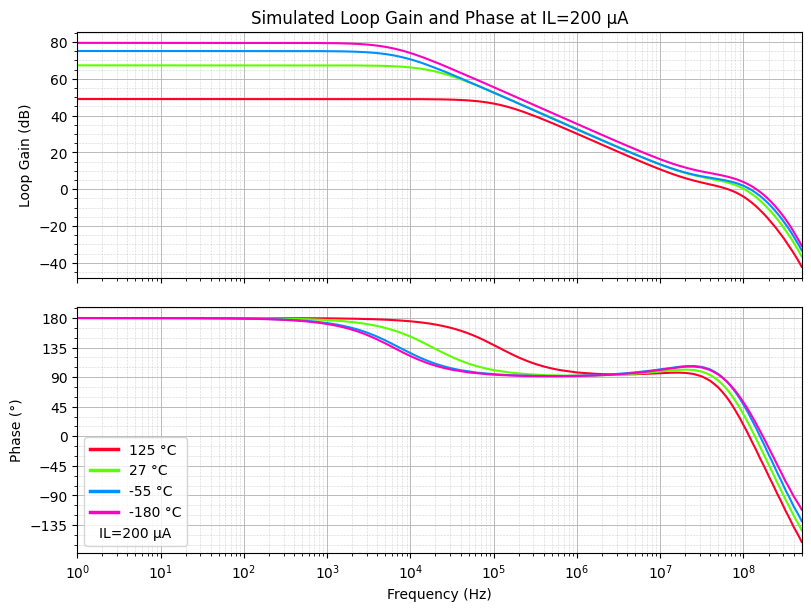

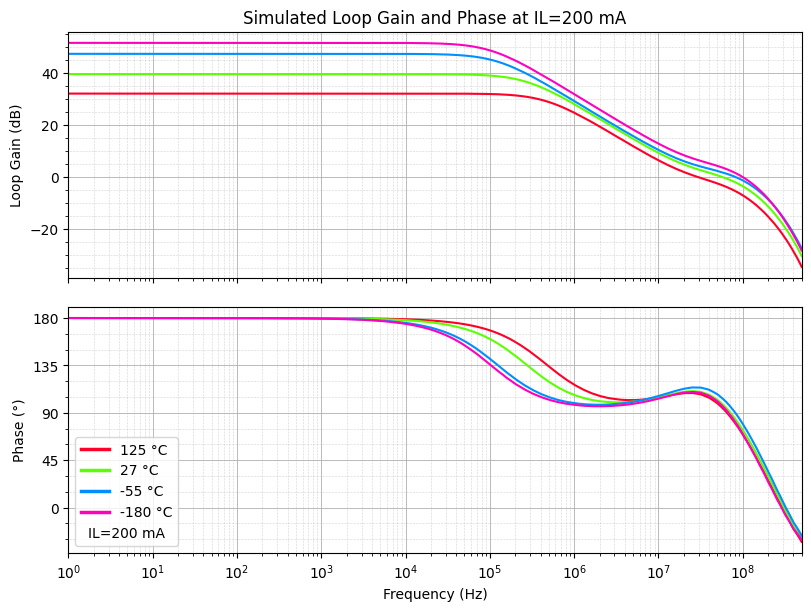

In [4]:
stab_dir = os.path.join(sim_dir, "Stability_Sims")
gain_data, [temps, ILs] = ICASL.read_cadence_csv(os.path.join(stab_dir, "TI_RLDO_LOOPGAIN.csv"), ["Temp", "IL"], new_x_label = "freq", new_y_label = "gain")
phase_data, [temps, ILs] = ICASL.read_cadence_csv(os.path.join(stab_dir, "TI_RLDO_LOOPGAIN_PHASE.csv"), ["Temp", "IL"], new_x_label = "freq", new_y_label = "phase")
temps.sort(reverse=True)

stab_metrics = []
for IL in ILs:
    fig, (ax_gain, ax_phase) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True, layout='constrained')
    fig.get_layout_engine().set(hspace=.08) # Sets height of space between magnitude and phase plots
    pretty_IL = f"{ICASL.set_precision(ICASL.scale(IL), 3)} {ICASL.prefix(IL)}A"

    # General axes adjustments
    for ax in (ax_gain, ax_phase):
        cm_num = 4
        cm=plt.get_cmap('gist_rainbow')
        ax.set_prop_cycle('color', cm(np.linspace(0, 1, cm_num))) # Will set each axes to have 4 colors across rainbow, gain and phase will correspond
        ax.set_xscale('log')
        #ax.set_xlim(plot_xmin, plot_xmax)
        ax.margins(x=0)
        ax.grid(which='major', linestyle='-', linewidth=0.6)
        ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10)))
        ax.grid(which='minor', linestyle=':', linewidth=0.4)

    # Gain-specific 
    ax_gain.set_ylabel('Loop Gain (dB)')
    ax_gain.set_title(f'Simulated Loop Gain and Phase at IL={pretty_IL}')
    ax_gain.yaxis.set_major_locator(MultipleLocator(20))
    ax_gain.yaxis.set_minor_locator(MultipleLocator(5))

    # Phase-specific
    ax_phase.set_xlabel('Frequency (Hz)')
    ax_phase.set_ylabel('Phase (°)')
    ax_phase.yaxis.set_major_locator(MultipleLocator(45))
    ax_phase.yaxis.set_minor_locator(MultipleLocator(15))

    # Plotting
    for temp in temps:
        gain_df = gain_data[temp][IL]
        f = np.geomspace(gain_df["freq"].values[0], gain_df["freq"].values[-1], 2000) # Linspace but on a logarithmic (geometric) scale                    
        gain_inter = np.interp(f, gain_df["freq"], gain_df["gain"])
        ax_gain.plot(f, gain_inter, label=f"{temp} °C")

        phase_df = phase_data[temp][IL]
        phase_inter = np.interp(f, phase_df["freq"], phase_df["phase"])
        ax_phase.plot(f, phase_inter, label=f"{temp} °C")
        
        if IL == .0002: test_f = 1e6
        if IL == .2: test_f = 4e6
        log = False
        DC_gain = gain_inter[0]
        if log: print(f"DC Gain: {DC_gain}")
        phase_margin = phase_margin_calc(gain_inter, phase_inter, log=log)
        gain_margin = gain_margin_calc(gain_inter, phase_inter, log=log)
        gain_bandwidth = gain_bandwidth_calc(f, gain_inter, test_f, log=log)
        crossover_f = crossover_freq_calc(f, gain_inter)

        stab_metrics.append({
            'IL (A)' : IL,
            'temp (C)' : temp,
            'DC_Loop_Gain_Magnitude (dB)': DC_gain,
            'phase_Margin (°)': phase_margin,
            'gain_Margin (dB)': gain_margin,
            'GB (Hz)' : gain_bandwidth,
            'crossover_freq' : crossover_f
        })

    ax_phase.legend(title='Temp (°C)')
    ICASL.finish_plot(fig, ax, "Sim_Plots", f"Stability_IL={IL}.png", legend=ax_phase.legend(), 
                      annotations = [f"IL={pretty_IL}"], cm=None, show=True)

pd.DataFrame(stab_metrics).to_csv('stability_metrics.csv', index=False, float_format='%.4g')

<h3> PSR </h3>

Layer 1 of keys for Temp: [125, -55, -180]
Layer 2 of keys for IL: [0.02, 0.2]
Final dataframe columns: ['freq', 'PSR']



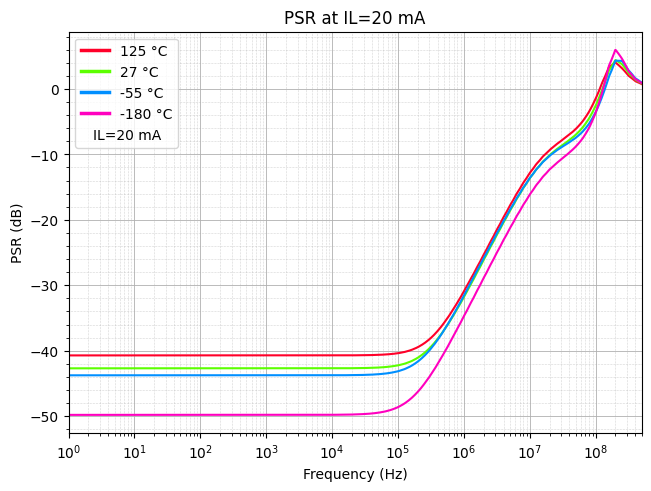

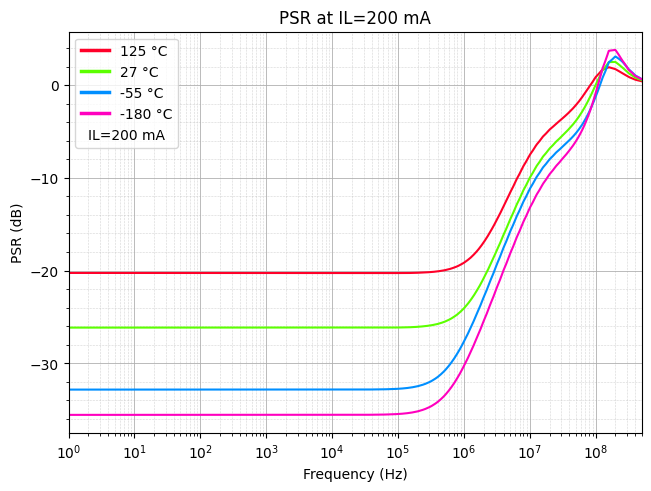

In [5]:
PSR_dir = os.path.join(sim_dir, "PSR_Sims")
PSR_data, [_, ILs] = ICASL.read_cadence_csv(os.path.join(PSR_dir, "TI_RLDO_NRT_PSR.csv"), ["Temp", "IL"], new_x_label = "freq", new_y_label = "PSR")

# Add to my usual data structure manually by renaming then combining the individual dataframes.
PSR_data_27C = {}
PSR_data_27C[.02] = ICASL.read_csv(os.path.join(PSR_dir, "TIRLDO_PSR_RT_20m.csv"))
PSR_data_27C[.2] = ICASL.read_csv(os.path.join(PSR_dir, "TIRLDO_PSR_RT_200m.csv"))
PSR_data_27C[.02].columns = ["freq", "PSR"]
PSR_data_27C[.2].columns = ["freq", "PSR"]
PSR_data[27] = PSR_data_27C

temps.sort(reverse=True)

PSR_metrics = []
for IL in ILs:
    pretty_IL = f"{ICASL.set_precision(ICASL.scale(IL), 3)} {ICASL.prefix(IL)}A"
    fig, ax = ICASL.start_plot(f"PSR at IL={pretty_IL}", f"Frequency (Hz)", 'PSR (dB)')

    # General axes adjustments
    ax.set_xscale('log')
    #ax.set_xlim(plot_xmin, plot_xmax)
    ax.margins(x=0)
    ax.grid(which='major', linestyle='-', linewidth=0.6)
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10)))
    ax.grid(which='minor', linestyle=':', linewidth=0.4)

    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(2))

    # Plotting
    for temp in temps:
        PSR_df = PSR_data[temp][IL]
        f = np.geomspace(PSR_df["freq"].values[0], PSR_df["freq"].values[-1], 2000) # Linspace but on a logarithmic (geometric) scale                    
        PSR_inter = np.interp(f, PSR_df["freq"], PSR_df["PSR"])
        ax.plot(f, PSR_inter, label=f"{temp} °C")
        #ax.plot(PSR_df["freq"], PSR_df["PSR"], label=f"{temp} °C")

        DC_PSR = PSR_inter[0]
        _100kHz_PSR = PSR_inter[f == find_closest(f, 100000)][0]

        PSR_metrics.append({
            'IL (A)' : IL,
            'temp (C)' : temp,
            'DC_PSR': DC_PSR,
            '100 kHz PSR': _100kHz_PSR,
        })

    ax_phase.legend(title='Temp (°C)')
    ICASL.finish_plot(fig, ax, "Sim_Plots", f"PSR_IL={IL}A.png", legend=ax.legend(), 
                      annotations = [f"IL={pretty_IL}"], show=True)

pd.DataFrame(PSR_metrics).to_csv('PSR_metrics.csv', index=False, float_format='%.4g')